# Risk Premia Strategy Backtests

## Purpose

Write file of 3-asset RP strategy returns, scaled to annualised volatility of 10%. (Rebalanced back to target vol every volLookback days)

Set the end date below. Other parameters are:
- initEq = 10000
- perShareComm = 0.005
- minCommPerOrder = 1
- rebalFrequency = 1 (rebalance frequency in months)
- capFrequency = 1 (frequency to capitalise profits. 0 is "don't capitalise")
- assetVolTarget = 0.05
- volLookback = 60

In [1]:
backtest_end_date = "2020-11-04"

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from pathlib import Path
import pickle

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Load prices from RData file
data_path = Path('..') / 'data' / 'prices.RData'
result = pyreadr.read_r(str(data_path))
prices = result['us_etf_prices']

# prices only for the three assets we want
assets = ['VTI', 'GLD', 'TLT']
prices = prices.loc[prices['ticker'].isin(assets)].copy()

# Convert date and sort
prices['date'] = pd.to_datetime(prices['date'])
prices = prices.sort_values('date').reset_index(drop=True)

print(f"Loaded {len(prices)} rows of price data")
prices.head()

Loaded 19893 rows of price data


,ticker,date,open,high,low,close,volume,dividends,closeadjusted
0,GLD,1995-01-04,39.935684,39.935684,39.935684,39.935684,0.0,0.0,39.935684
1,TLT,1995-01-04,40.786830,40.786830,40.786830,40.786830,0.0,0.0,21.563399
2,VTI,1995-01-04,18.971110,18.971110,18.971110,18.971110,0.0,0.0,13.609578
3,GLD,1995-01-05,39.903083,39.903083,39.903083,39.903083,0.0,0.0,39.903083
4,TLT,1995-01-05,40.562430,40.562430,40.562430,40.562430,0.0,0.0,21.444761


## Plot Cumulative Returns to Verify Data

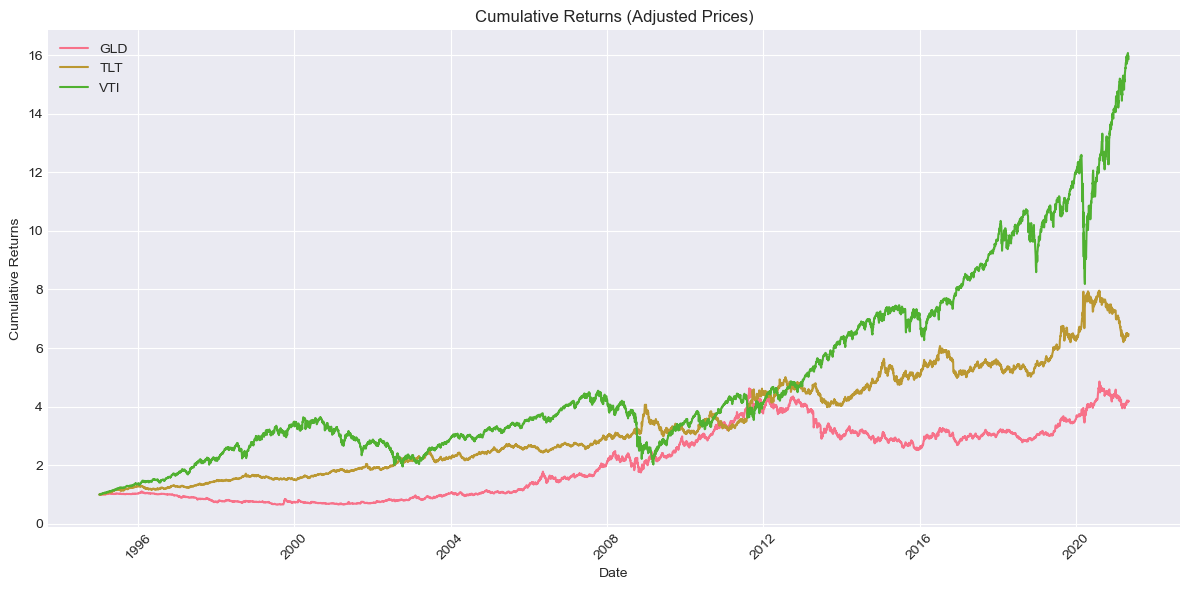

In [3]:
# Calculate returns from adjusted close
plot_data = prices.copy()
plot_data = plot_data.sort_values(['ticker', 'date'])
plot_data['returns'] = plot_data.groupby('ticker')['closeadjusted'].pct_change()
plot_data = plot_data.dropna(subset=['returns'])
plot_data['cumreturns'] = plot_data.groupby('ticker')['returns'].apply(
    lambda x: (1 + x).cumprod()
).reset_index(level=0, drop=True)

# Plot
plt.figure(figsize=(12, 6))
for ticker in plot_data['ticker'].unique():
    ticker_data = plot_data[plot_data['ticker'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['cumreturns'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns (Adjusted Prices)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Backtest Setup

Calculate monthly prices and start/end dates

In [4]:
# Get month-end dates
prices_with_month = prices.copy()
prices_with_month['year'] = prices_with_month['date'].dt.year
prices_with_month['month'] = prices_with_month['date'].dt.month

monthends = prices_with_month.groupby(['year', 'month'])['date'].max().reset_index()

# Get monthly prices (use closeadjusted)
monthlyprices = prices.merge(monthends, on='date')[['ticker', 'date', 'closeadjusted']]
monthlyprices = monthlyprices.rename(columns={'closeadjusted': 'close'})

# Set dates
startDate = monthlyprices['date'].min()
endDate = pd.to_datetime(backtest_end_date)
initDate = startDate - pd.Timedelta(days=1)

print(f"Start Date: {startDate}")
print(f"End Date: {endDate}")
print(f"Number of monthly periods: {len(monthlyprices['date'].unique())}")
monthlyprices.head()

Start Date: 1995-01-31 00:00:00
End Date: 2020-11-04 00:00:00
Number of monthly periods: 317


,ticker,date,close
0,GLD,1995-01-31,39.843994
1,TLT,1995-01-31,22.056646
2,VTI,1995-01-31,13.909370
3,VTI,1995-02-28,14.449024
4,TLT,1995-02-28,22.659934


# Tab 1: Equal Initial Weight Buy and Hold

Here are the inputs for this strategy:

In [5]:
initEq = 10000  # Initial equity ($1000 to $1 million)
perShareComm = 0.005  # Per-share commission (0.001 to 0.02)
minCommPerOrder = 1  # Minimum commission per order (0 to 5)

This strategy assumes rebalFrequency = capFrequency = 0 (no rebalancing)

In [6]:
# Calculate initial shares - equal dollar weight
initial_prices = monthlyprices[monthlyprices['date'] == startDate].copy()
shares = initial_prices.copy()
shares['shares'] = np.floor((initEq / 3) / shares['close']).astype(int)
shares = shares[['ticker', 'shares']]

# Merge shares with all prices
ew_norebal = monthlyprices.merge(shares, on='ticker')
ew_norebal['exposure'] = ew_norebal['shares'] * ew_norebal['close']

# Calculate trades
ew_norebal = ew_norebal.sort_values(['ticker', 'date'])
ew_norebal['trades'] = ew_norebal.groupby('ticker')['shares'].diff().fillna(ew_norebal['shares'])
ew_norebal['tradevalue'] = ew_norebal['trades'] * ew_norebal['close']

# Calculate commissions
ew_norebal['commission'] = np.abs(ew_norebal['trades']) * perShareComm
ew_norebal.loc[ew_norebal['commission'] < minCommPerOrder, 'commission'] = minCommPerOrder
ew_norebal.loc[ew_norebal['trades'] == 0, 'commission'] = 0

# Calculate initial cash balance
initial_investment = ew_norebal[ew_norebal['date'] == startDate]
initcashbal = initEq - initial_investment['exposure'].sum() - initial_investment['commission'].sum()

# Create cash rows
cash_rows = []
for date in ew_norebal['date'].unique():
    if date == startDate:
        tradevalue = initcashbal - initEq
    else:
        tradevalue = 0
    
    cash_rows.append({
        'ticker': 'Cash',
        'date': date,
        'close': 0,
        'shares': 0,
        'exposure': initcashbal,
        'trades': 0,
        'tradevalue': tradevalue,
        'commission': 0
    })

cash_df = pd.DataFrame(cash_rows)
ew_norebal = pd.concat([ew_norebal, cash_df], ignore_index=True)
ew_norebal = ew_norebal.sort_values('date').reset_index(drop=True)

print(f"Buy and hold backtest created with {len(ew_norebal)} rows")
ew_norebal.head(10)

Buy and hold backtest created with 1268 rows


,ticker,date,close,shares,exposure,trades,tradevalue,commission
0,GLD,1995-01-31,39.843994,83,3307.051467,83.0,3307.051467,1.000
1,VTI,1995-01-31,13.909370,239,3324.339521,239.0,3324.339521,1.195
2,TLT,1995-01-31,22.056646,151,3330.553523,151.0,3330.553523,1.000
3,Cash,1995-01-31,0.000000,0,34.860489,0.0,-9965.139511,0.000
4,GLD,1995-02-28,39.984992,83,3318.754371,0.0,0.000000,0.000
5,VTI,1995-02-28,14.449024,239,3453.316752,0.0,0.000000,0.000
6,TLT,1995-02-28,22.659934,151,3421.649968,0.0,0.000000,0.000
7,Cash,1995-02-28,0.000000,0,34.860489,0.0,0.000000,0.000
8,GLD,1995-03-31,41.619927,83,3454.453949,0.0,0.000000,0.000
9,TLT,1995-03-31,22.824134,151,3446.444298,0.0,0.000000,0.000


## Visualizations

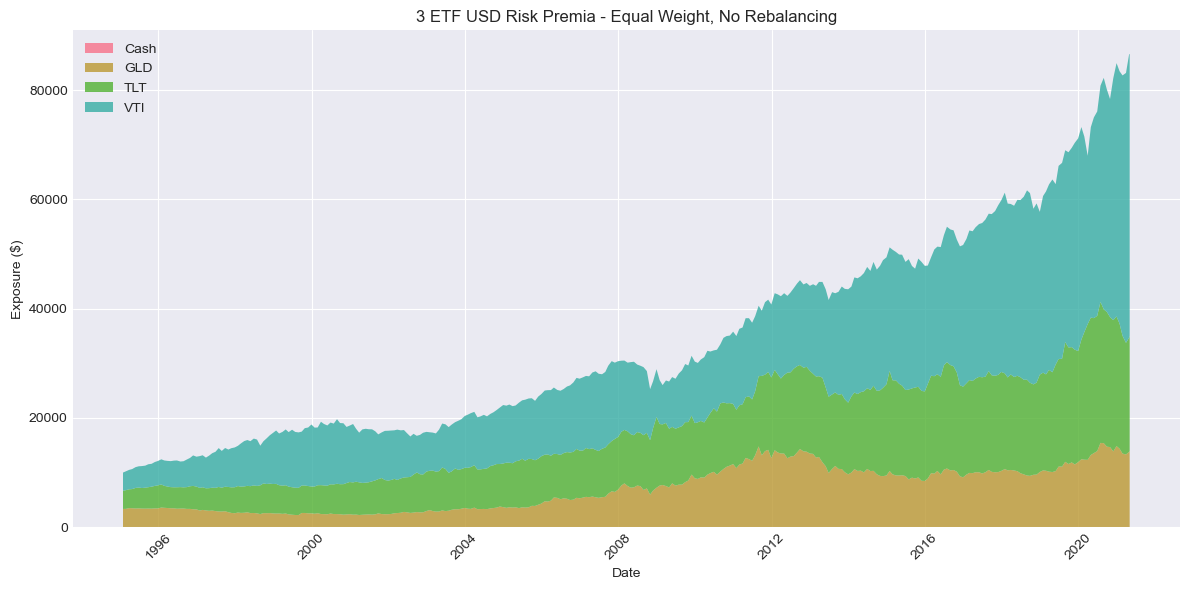

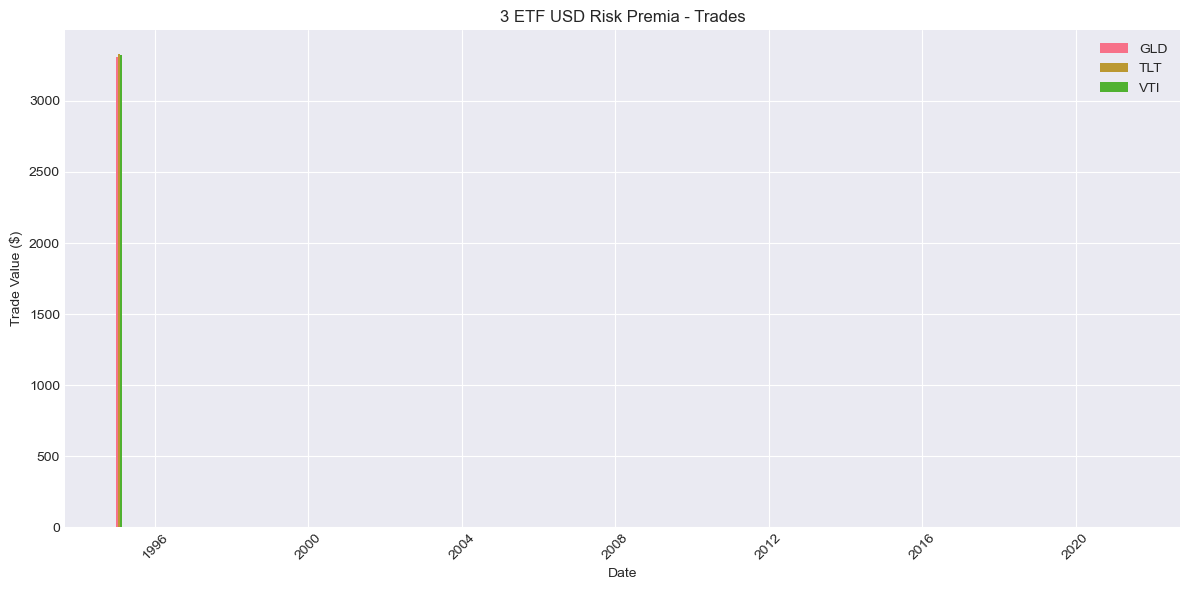

<Figure size 1200x600 with 0 Axes>

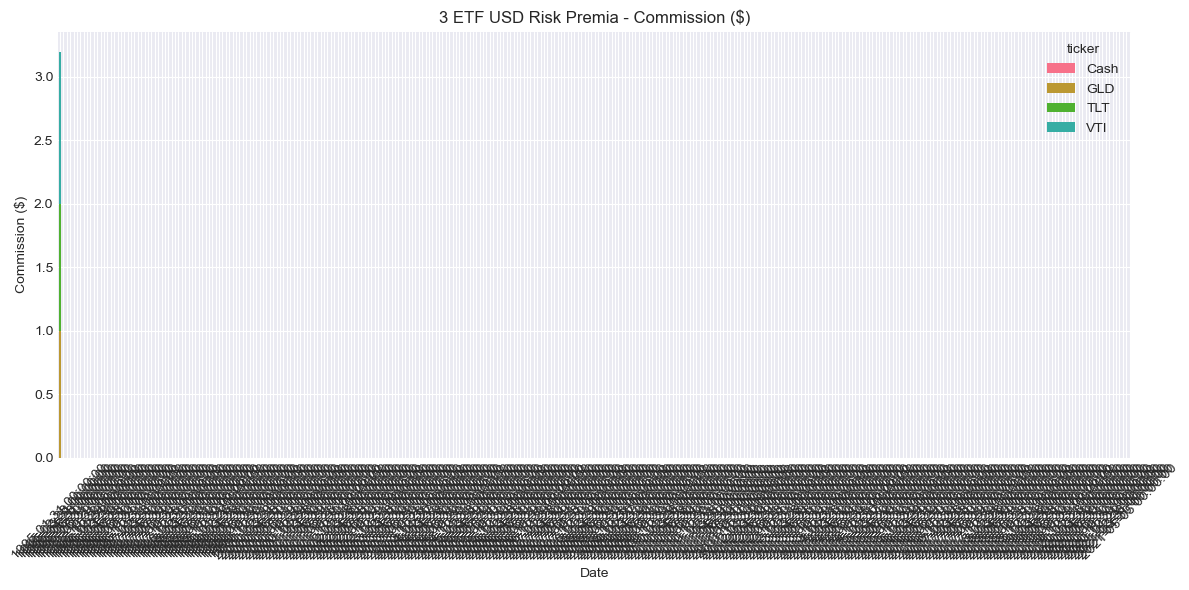

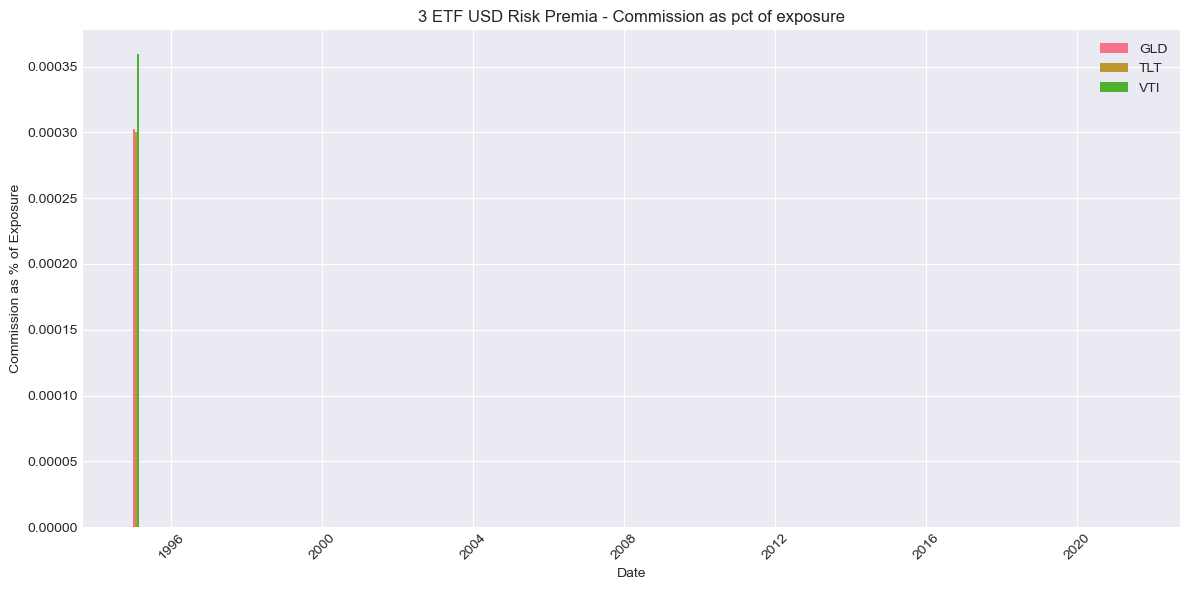

In [7]:
# Stacked area chart
pivot_data = ew_norebal.pivot(index='date', columns='ticker', values='exposure')
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_data.index, pivot_data.T, labels=pivot_data.columns, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Exposure ($)')
plt.title('3 ETF USD Risk Premia - Equal Weight, No Rebalancing')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trades chart
trades_data = ew_norebal[ew_norebal['ticker'] != 'Cash']
fig, ax = plt.subplots(figsize=(12, 6))
tickers = sorted(trades_data['ticker'].unique())
width = 20  # bar width in days
for i, ticker in enumerate(tickers):
    ticker_trades = trades_data[trades_data['ticker'] == ticker]
    offset = (i - len(tickers)/2) * width
    ax.bar(ticker_trades['date'] + pd.Timedelta(days=offset), 
           ticker_trades['tradevalue'], 
           width=width, 
           label=ticker)
ax.set_xlabel('Date')
ax.set_ylabel('Trade Value ($)')
ax.set_title('3 ETF USD Risk Premia - Trades')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Commission chart
plt.figure(figsize=(12, 6))
pivot_comm = ew_norebal.pivot(index='date', columns='ticker', values='commission')
pivot_comm.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Commission ($)')
plt.title('3 ETF USD Risk Premia - Commission ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Commission as percentage of exposure
comm_pct = ew_norebal.copy()
comm_pct['commissionpct'] = comm_pct['commission'] / comm_pct['exposure'].replace(0, np.nan)
comm_pct = comm_pct[comm_pct['ticker'] != 'Cash']

fig, ax = plt.subplots(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    ticker_data = comm_pct[comm_pct['ticker'] == ticker]
    offset = (i - len(tickers)/2) * width
    ax.bar(ticker_data['date'] + pd.Timedelta(days=offset), 
           ticker_data['commissionpct'], 
           width=width, 
           label=ticker)
ax.set_xlabel('Date')
ax.set_ylabel('Commission as % of Exposure')
ax.set_title('3 ETF USD Risk Premia - Commission as pct of exposure')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Performance Metrics

In [8]:
# Calculate portfolio returns
norebal_portfolioreturn = ew_norebal.groupby('date').agg({
    'exposure': 'sum',
    'commission': 'sum'
}).reset_index()
norebal_portfolioreturn.columns = ['date', 'totalequity', 'totalcommission']
norebal_portfolioreturn = norebal_portfolioreturn.sort_values('date')
norebal_portfolioreturn['returns'] = norebal_portfolioreturn['totalequity'].pct_change()

# Performance metrics
returns = norebal_portfolioreturn['returns'].dropna()
annual_return = (1 + returns.mean())**12 - 1
annual_vol = returns.std() * np.sqrt(12)
sharpe = annual_return / annual_vol

# Maximum drawdown
cumulative = (1 + returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print("Summary Performance Metrics:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"\nTotal Commission: ${norebal_portfolioreturn['totalcommission'].sum():.2f}")
print(f"Turnover: 0 (buy and hold)")

totalprofit = norebal_portfolioreturn['totalequity'].iloc[-1] - initEq
costprofit = norebal_portfolioreturn['totalcommission'].sum() / totalprofit
print(f"Total Profit: ${totalprofit:.2f}")
print(f"Trading costs as % of profit: {costprofit:.2%}")

Summary Performance Metrics:
Annualized Return: 8.94%
Annualized Volatility: 8.52%
Sharpe Ratio: 1.05
Maximum Drawdown: -17.16%

Total Commission: $3.20
Turnover: 0 (buy and hold)
Total Profit: $76590.05
Trading costs as % of profit: 0.00%


# Tab 2: Equal Dollar Weight with Rebalancing

Inputs for this strategy:

In [9]:
initEq = 10000  # Initial equity
perShareComm = 0.005  # Per-share commission
minCommPerOrder = 1  # Minimum commission per order
rebalFrequency = 1  # Rebalance frequency in months (1 to 12)
capFrequency = 1  # Frequency to capitalise profits (0 to 12, 0 = don't capitalise)

In [10]:
assert rebalFrequency > 0, "rebalFrequency must be > 0"

# Create wide dataframes for vectorized backtest
wideprices = monthlyprices.pivot(index='date', columns='ticker', values='close')

# Initialize tracking variables
rowlist = []
cash = initEq
sharepos = np.array([0., 0., 0.])
equity = initEq
capEquity = initEq  # Sticky equity for capitalisation frequency

# Iterate through prices
for i in range(len(wideprices)):
    currentdate = wideprices.index[i]
    currentprice = wideprices.iloc[i].values
    equity = np.sum(sharepos * currentprice) + cash
    
    # Update capEquity if it's re-capitalisation time
    if capFrequency > 0 and i % capFrequency == 0:
        capEquity = equity
    
    # Update position sizing if it's rebalance time
    if i == 0 or i % rebalFrequency == 0:
        targetshares = np.floor((capEquity / 3) / currentprice)
    
    trades = targetshares - sharepos
    tradevalue = trades * currentprice
    commissions = np.abs(trades) * perShareComm
    commissions = np.where(commissions < minCommPerOrder, minCommPerOrder, commissions)
    
    # Adjust cash
    cash = cash - np.sum(tradevalue) - np.sum(commissions)
    sharepos = targetshares.copy()
    sharevalue = sharepos * currentprice
    equity = np.sum(sharevalue) + cash
    
    # Create dataframe row
    tickers = wideprices.columns.tolist()
    row_df = pd.DataFrame({
        'ticker': ['cash'] + tickers,
        'date': [currentdate] * 4,
        'close': [0] + currentprice.tolist(),
        'shares': [0] + sharepos.tolist(),
        'exposure': [cash] + sharevalue.tolist(),
        'sharetrades': [0] + trades.tolist(),
        'tradevalue': [-np.sum(tradevalue)] + tradevalue.tolist(),
        'commission': [0] + commissions.tolist()
    })
    
    rowlist.append(row_df)

# Combine into single dataframe
ew_rebal = pd.concat(rowlist, ignore_index=True)

print(f"Equal-weight rebalancing backtest created with {len(ew_rebal)} rows")
ew_rebal.head(10)

Equal-weight rebalancing backtest created with 1268 rows


,ticker,date,close,shares,exposure,sharetrades,tradevalue,commission
0,cash,1995-01-31,0.000000,0.0,34.860489,0.0,-9961.944511,0.000
1,GLD,1995-01-31,39.843994,83.0,3307.051467,83.0,3307.051467,1.000
2,TLT,1995-01-31,22.056646,151.0,3330.553523,151.0,3330.553523,1.000
3,VTI,1995-01-31,13.909370,239.0,3324.339521,239.0,3324.339521,1.195
4,cash,1995-02-28,0.000000,0.0,32.346534,0.0,0.486045,0.000
5,GLD,1995-02-28,39.984992,85.0,3398.724356,2.0,79.969985,1.000
6,TLT,1995-02-28,22.659934,150.0,3398.990034,-1.0,-22.659934,1.000
7,VTI,1995-02-28,14.449024,235.0,3395.520656,-4.0,-57.796096,1.000
8,cash,1995-03-31,0.000000,0.0,2.494058,0.0,-26.852476,0.000
9,GLD,1995-03-31,41.619927,84.0,3496.073876,-1.0,-41.619927,1.000


## Visualizations

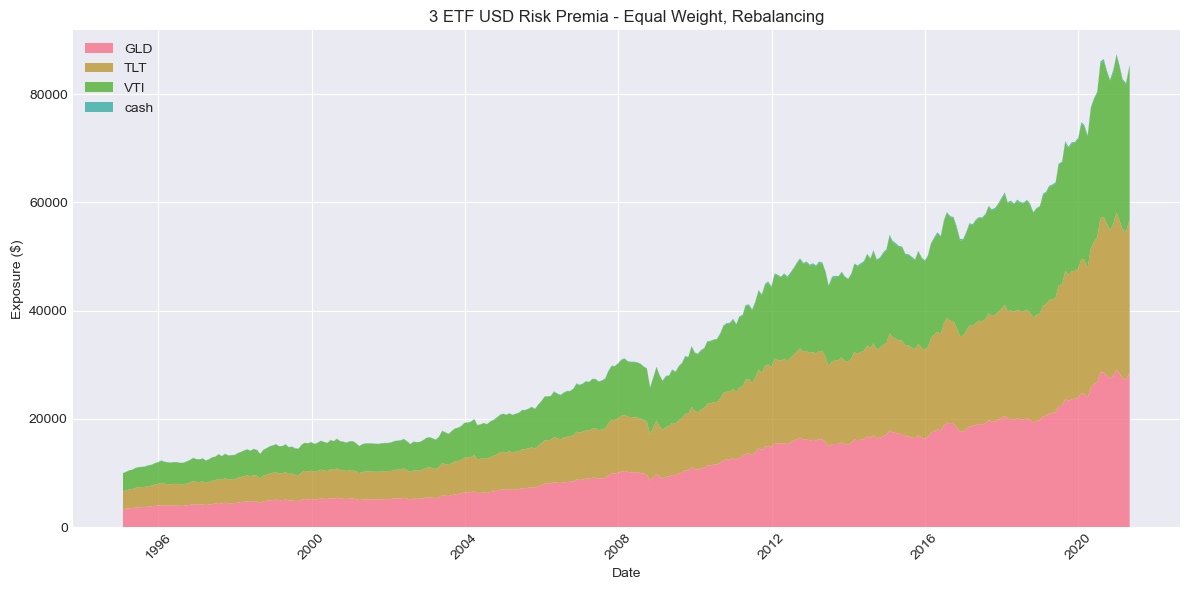

<Figure size 1200x600 with 0 Axes>

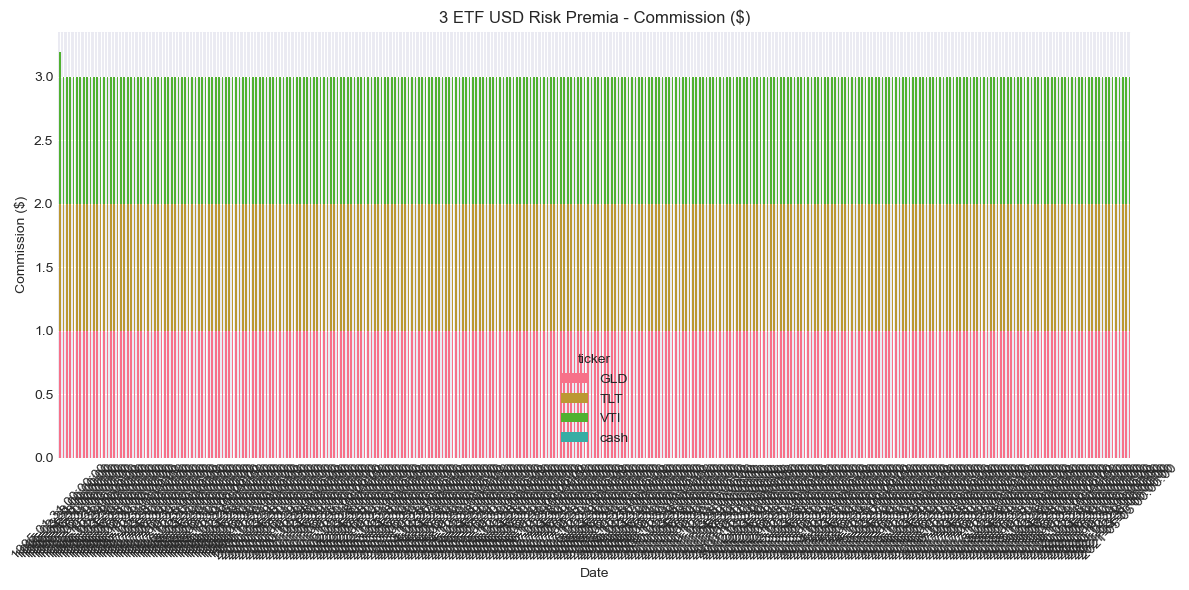

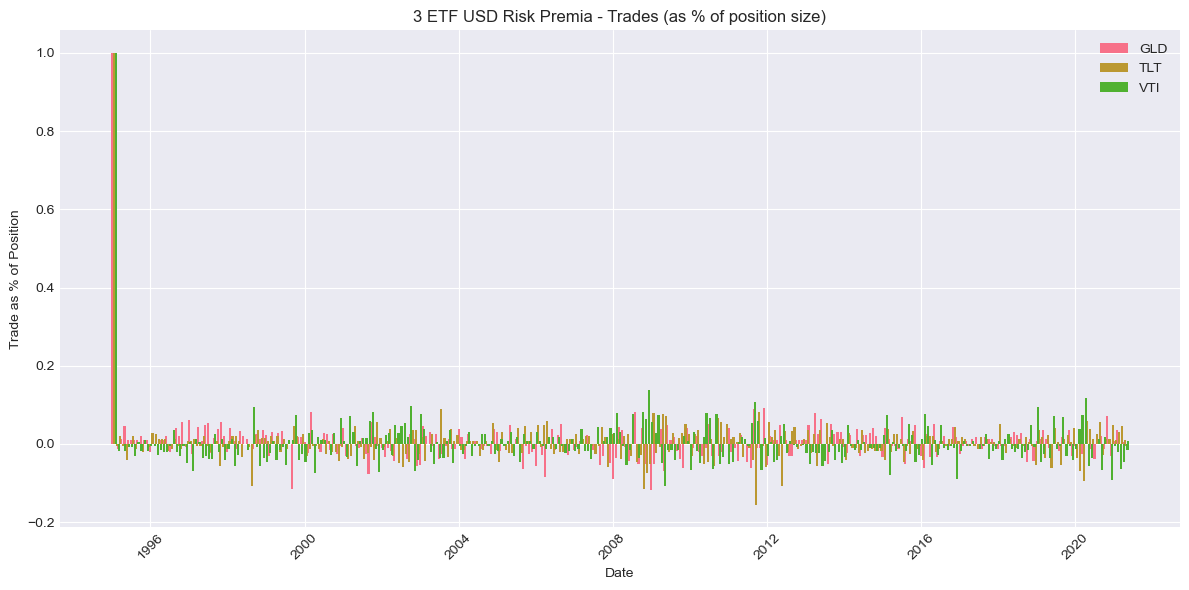

In [11]:
# Stacked area chart
pivot_data = ew_rebal.pivot(index='date', columns='ticker', values='exposure')
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_data.index, pivot_data.T, labels=pivot_data.columns, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Exposure ($)')
plt.title('3 ETF USD Risk Premia - Equal Weight, Rebalancing')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Commission chart
plt.figure(figsize=(12, 6))
pivot_comm = ew_rebal.pivot(index='date', columns='ticker', values='commission')
pivot_comm.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Commission ($)')
plt.title('3 ETF USD Risk Premia - Commission ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trades as % of position size
trades_pct = ew_rebal[ew_rebal['ticker'] != 'cash'].copy()
trades_pct['tradepct'] = trades_pct['tradevalue'] / trades_pct['exposure'].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(12, 6))
tickers = sorted(trades_pct['ticker'].unique())
width = 20
for i, ticker in enumerate(tickers):
    ticker_data = trades_pct[trades_pct['ticker'] == ticker]
    offset = (i - len(tickers)/2) * width
    ax.bar(ticker_data['date'] + pd.Timedelta(days=offset), 
           ticker_data['tradepct'], 
           width=width, 
           label=ticker)
ax.set_xlabel('Date')
ax.set_ylabel('Trade as % of Position')
ax.set_title('3 ETF USD Risk Premia - Trades (as % of position size)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Performance Metrics

In [12]:
# Calculate portfolio returns
rebal_portfolioreturn = ew_rebal.groupby('date').agg({
    'exposure': 'sum',
    'commission': 'sum'
}).reset_index()
rebal_portfolioreturn.columns = ['date', 'totalequity', 'totalcommission']
rebal_portfolioreturn = rebal_portfolioreturn.sort_values('date')
rebal_portfolioreturn['returns'] = rebal_portfolioreturn['totalequity'].pct_change()

# Performance metrics
returns = rebal_portfolioreturn['returns'].dropna()
annual_return = (1 + returns.mean())**12 - 1
annual_vol = returns.std() * np.sqrt(12)
sharpe = annual_return / annual_vol

# Maximum drawdown
cumulative = (1 + returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print("Summary Performance Metrics:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"\nTotal Commission: ${rebal_portfolioreturn['totalcommission'].sum():.2f}")

# Calculate turnover
totalselltrades = ew_rebal[
    (ew_rebal['ticker'] != 'cash') & (ew_rebal['tradevalue'] < 0)
]['tradevalue'].sum()
meanequity = rebal_portfolioreturn['totalequity'].mean()
num_years = (endDate.year - startDate.year)
turnover = -totalselltrades / (meanequity * num_years) if num_years > 0 else 0
print(f"Annual Turnover: {turnover:.2f}")

totalprofit = rebal_portfolioreturn['totalequity'].iloc[-1] - initEq
costprofit = rebal_portfolioreturn['totalcommission'].sum() / totalprofit
print(f"Total Profit: ${totalprofit:.2f}")
print(f"Trading costs as % of profit: {costprofit:.2%}")

Summary Performance Metrics:
Annualized Return: 8.85%
Annualized Volatility: 8.24%
Sharpe Ratio: 1.07
Maximum Drawdown: -17.01%

Total Commission: $951.19
Annual Turnover: 0.17
Total Profit: $75372.25
Trading costs as % of profit: 1.26%


# Tab 3: Simple Risk Parity

Inputs for this strategy:

In [13]:
initEq = 10000  # Initial equity
perShareComm = 0.005  # Per-share commission
minCommPerOrder = 1  # Minimum commission per order
rebalFrequency = 1  # Rebalance frequency in months
capFrequency = 1  # Frequency to capitalise profits
assetVolTarget = 0.05  # Asset volatility target (0.01 to 0.1)
volLookback = 30  # Volatility lookback period in days (5 to 250)

## Calculate Volatility Sizing

In [14]:
# Calculate daily volatility target sizing
theosize_daily = prices.copy()
theosize_daily = theosize_daily.sort_values(['ticker', 'date'])

# Calculate returns
theosize_daily['returns'] = theosize_daily.groupby('ticker')['closeadjusted'].pct_change()

# Calculate rolling volatility (annualized)
theosize_daily['vol'] = theosize_daily.groupby('ticker')['returns'].transform(
    lambda x: x.rolling(window=volLookback, min_periods=volLookback).std() * np.sqrt(252)
)

# Calculate theoretical size (lagged)
theosize_daily['theosize'] = (assetVolTarget / theosize_daily['vol']).shift(1)

# Calculate total size and adjustment factor to constrain leverage to 1
totalsize = theosize_daily.groupby('date')['theosize'].sum().reset_index()
totalsize.columns = ['date', 'totalsize']
totalsize['adjfactor'] = np.where(totalsize['totalsize'] > 1, 1 / totalsize['totalsize'], 1)

# Apply constraint
theosize_constrained = theosize_daily.merge(totalsize, on='date')
theosize_constrained['theosize_constrained'] = (
    theosize_constrained['theosize'] * theosize_constrained['adjfactor']
)
theosize_constrained = theosize_constrained[[
    'ticker', 'date', 'closeadjusted', 'returns', 'vol', 'theosize', 'theosize_constrained'
]].dropna()

# Get month-end snapshots
volsizeprices = monthlyprices.merge(
    theosize_constrained[['ticker', 'date', 'theosize_constrained']], 
    on=['ticker', 'date']
)

print(f"Calculated volatility sizing for {len(volsizeprices)} rows")
volsizeprices.head()

Calculated volatility sizing for 948 rows


,ticker,date,close,theosize_constrained
0,VTI,1995-02-28,14.449024,0.335171
1,TLT,1995-02-28,22.659934,0.291717
2,GLD,1995-02-28,39.984992,0.373112
3,GLD,1995-03-31,41.619927,0.371687
4,TLT,1995-03-31,22.824134,0.307152


## Plot Theoretical Constrained Sizing

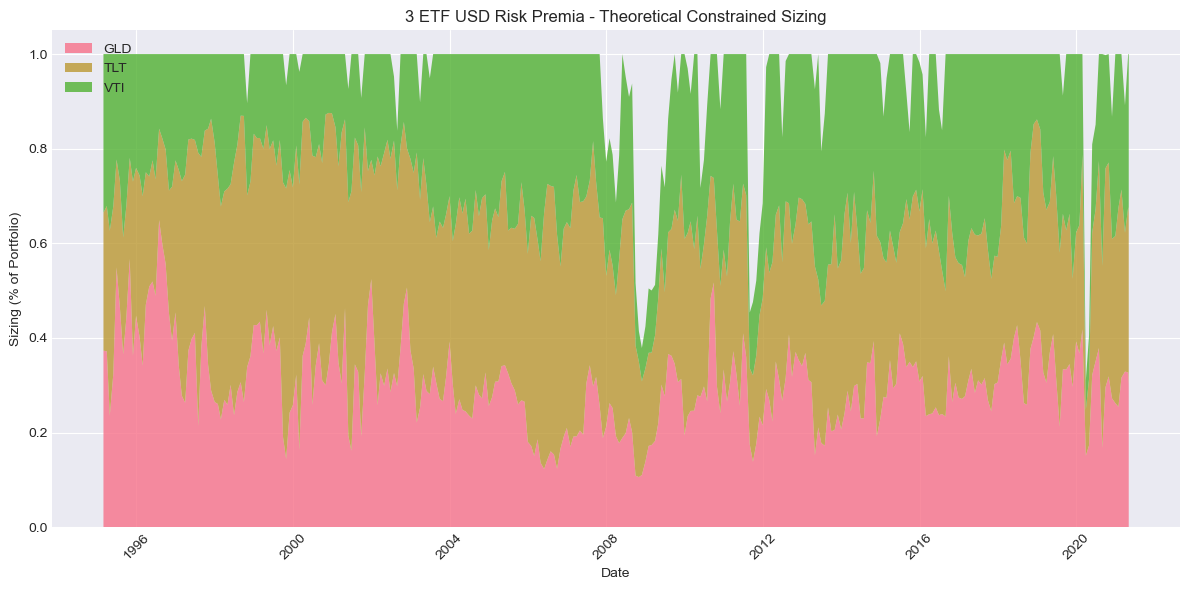

In [15]:
# Stacked area chart of theoretical sizing
pivot_sizing = volsizeprices.pivot(index='date', columns='ticker', values='theosize_constrained')
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_sizing.index, pivot_sizing.T, labels=pivot_sizing.columns, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Sizing (% of Portfolio)')
plt.title('3 ETF USD Risk Premia - Theoretical Constrained Sizing')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Backtest Volatility Targeting Strategy

In [16]:
assert rebalFrequency > 0, "rebalFrequency must be > 0"

# Create wide dataframes
wideprices = volsizeprices.pivot(index='date', columns='ticker', values='close')
widetheosize = volsizeprices.pivot(index='date', columns='ticker', values='theosize_constrained')

# Initialize tracking variables
rowlist = []
cash = initEq
sharepos = np.array([0., 0., 0.])
equity = initEq
capEquity = initEq

# Iterate through prices
for i in range(len(wideprices)):
    currentdate = wideprices.index[i]
    currentprice = wideprices.iloc[i].values
    currenttheosize = widetheosize.iloc[i].values
    equity = np.sum(sharepos * currentprice) + cash
    
    # Update capEquity if it's re-capitalisation time
    if capFrequency > 0 and i % capFrequency == 0:
        capEquity = equity
    
    # Update position sizing if it's rebalance time
    if i == 0 or i % rebalFrequency == 0:
        targetshares = np.floor((capEquity * currenttheosize) / currentprice)
    
    trades = targetshares - sharepos
    tradevalue = trades * currentprice
    commissions = np.abs(trades) * perShareComm
    commissions = np.where(commissions < minCommPerOrder, minCommPerOrder, commissions)
    
    # Adjust cash
    cash = cash - np.sum(tradevalue) - np.sum(commissions)
    sharepos = targetshares.copy()
    sharevalue = sharepos * currentprice
    equity = np.sum(sharevalue) + cash
    
    # Create dataframe row
    tickers = wideprices.columns.tolist()
    row_df = pd.DataFrame({
        'ticker': ['cash'] + tickers,
        'date': [currentdate] * 4,
        'close': [0] + currentprice.tolist(),
        'shares': [0] + sharepos.tolist(),
        'exposure': [cash] + sharevalue.tolist(),
        'sharetrades': [0] + trades.tolist(),
        'tradevalue': [-np.sum(tradevalue)] + tradevalue.tolist(),
        'commission': [0] + commissions.tolist()
    })
    
    rowlist.append(row_df)

# Combine into single dataframe
volsize_rebal = pd.concat(rowlist, ignore_index=True)

print(f"Risk parity backtest created with {len(volsize_rebal)} rows")
volsize_rebal.head(10)

Risk parity backtest created with 1264 rows


,ticker,date,close,shares,exposure,sharetrades,tradevalue,commission
0,cash,1995-02-28,0.000000,0.0,40.044649,0.0,-9956.800351,0.000
1,GLD,1995-02-28,39.984992,93.0,3718.604295,93.0,3718.604295,1.000
2,TLT,1995-02-28,22.659934,128.0,2900.471496,128.0,2900.471496,1.000
3,VTI,1995-02-28,14.449024,231.0,3337.724560,231.0,3337.724560,1.155
4,cash,1995-03-31,0.000000,0.0,40.801816,0.0,3.757167,0.000
5,GLD,1995-03-31,41.619927,91.0,3787.413365,-2.0,-83.239854,1.000
6,TLT,1995-03-31,22.824134,138.0,3149.730550,10.0,228.241344,1.000
7,VTI,1995-03-31,14.875866,221.0,3287.566326,-10.0,-148.758657,1.000
8,cash,1995-04-28,0.000000,0.0,12.952239,0.0,-24.849578,0.000
9,GLD,1995-04-28,41.364010,59.0,2440.476596,-32.0,-1323.648323,1.000


## Visualizations

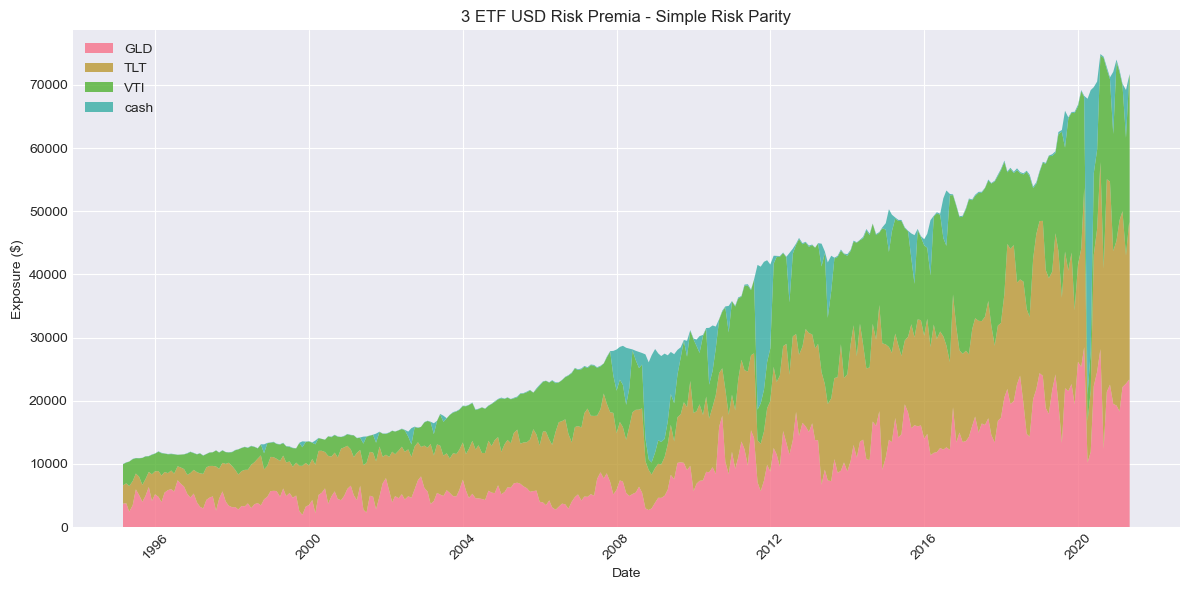

<Figure size 1200x600 with 0 Axes>

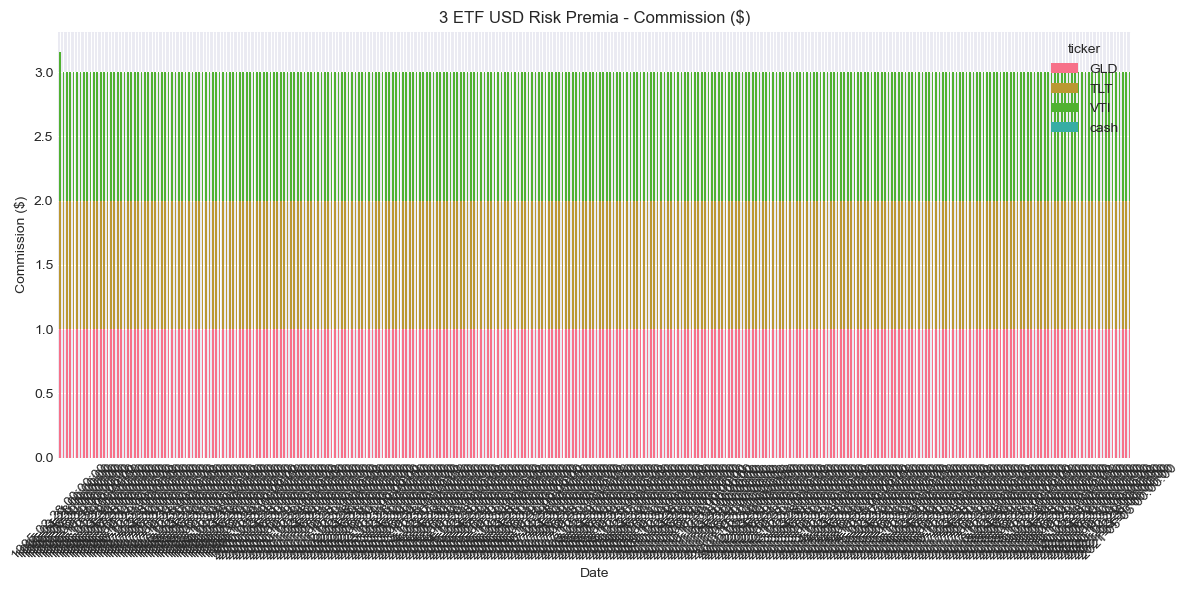

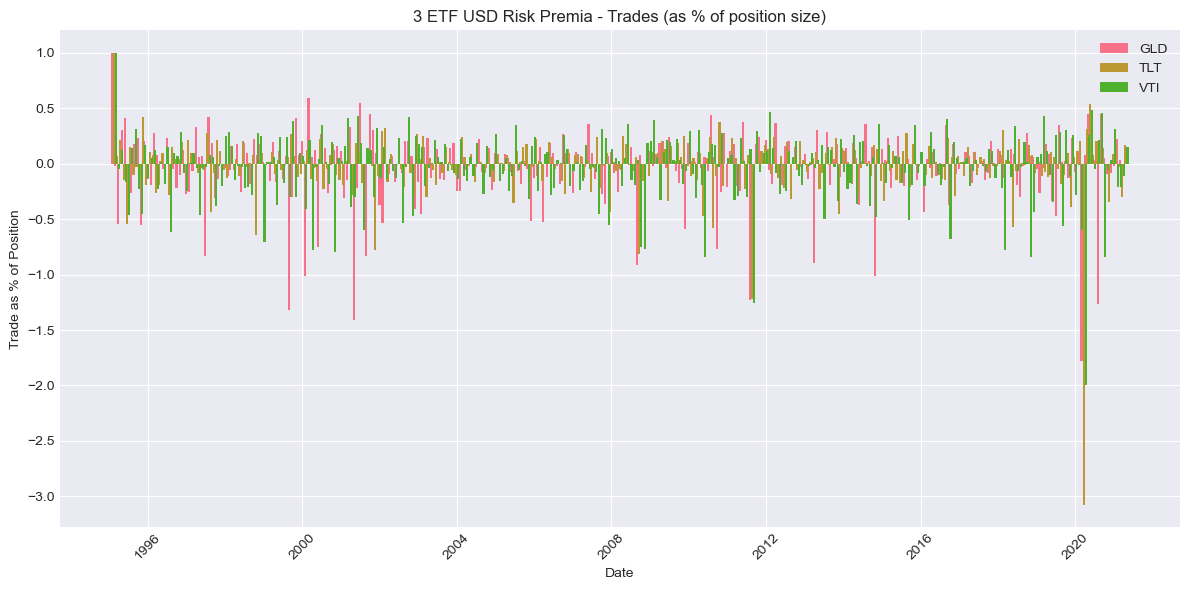

In [17]:
# Stacked area chart
pivot_data = volsize_rebal.pivot(index='date', columns='ticker', values='exposure')
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_data.index, pivot_data.T, labels=pivot_data.columns, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Exposure ($)')
plt.title('3 ETF USD Risk Premia - Simple Risk Parity')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Commission chart
plt.figure(figsize=(12, 6))
pivot_comm = volsize_rebal.pivot(index='date', columns='ticker', values='commission')
pivot_comm.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Commission ($)')
plt.title('3 ETF USD Risk Premia - Commission ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trades as % of position size
trades_pct = volsize_rebal[volsize_rebal['ticker'] != 'cash'].copy()
trades_pct['tradepct'] = trades_pct['tradevalue'] / trades_pct['exposure'].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(12, 6))
tickers = sorted(trades_pct['ticker'].unique())
width = 20
for i, ticker in enumerate(tickers):
    ticker_data = trades_pct[trades_pct['ticker'] == ticker]
    offset = (i - len(tickers)/2) * width
    ax.bar(ticker_data['date'] + pd.Timedelta(days=offset), 
           ticker_data['tradepct'], 
           width=width, 
           label=ticker)
ax.set_xlabel('Date')
ax.set_ylabel('Trade as % of Position')
ax.set_title('3 ETF USD Risk Premia - Trades (as % of position size)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Performance Metrics

In [18]:
# Calculate portfolio returns
volsize_portfolioreturn = volsize_rebal.groupby('date').agg({
    'exposure': 'sum',
    'commission': 'sum'
}).reset_index()
volsize_portfolioreturn.columns = ['date', 'totalequity', 'totalcommission']
volsize_portfolioreturn = volsize_portfolioreturn.sort_values('date')
volsize_portfolioreturn['returns'] = volsize_portfolioreturn['totalequity'].pct_change()

# Performance metrics
returns = volsize_portfolioreturn['returns'].dropna()
annual_return = (1 + returns.mean())**12 - 1
annual_vol = returns.std() * np.sqrt(12)
sharpe = annual_return / annual_vol

# Maximum drawdown
cumulative = (1 + returns).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print("Summary Performance Metrics:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"\nTotal Commission: ${volsize_portfolioreturn['totalcommission'].sum():.2f}")

# Calculate turnover
totalselltrades = volsize_rebal[
    (volsize_rebal['ticker'] != 'cash') & (volsize_rebal['tradevalue'] < 0)
]['tradevalue'].sum()
meanequity = volsize_portfolioreturn['totalequity'].mean()
num_years = (endDate.year - startDate.year)
turnover = -totalselltrades / (meanequity * num_years) if num_years > 0 else 0
print(f"Annual Turnover: {turnover:.2f}")

totalprofit = volsize_portfolioreturn['totalequity'].iloc[-1] - initEq
costprofit = volsize_portfolioreturn['totalcommission'].sum() / totalprofit
print(f"Total Profit: ${totalprofit:.2f}")
print(f"Trading costs as % of profit: {costprofit:.2%}")

Summary Performance Metrics:
Annualized Return: 8.06%
Annualized Volatility: 7.06%
Sharpe Ratio: 1.14
Maximum Drawdown: -9.42%

Total Commission: $948.15
Annual Turnover: 0.97
Total Profit: $61718.61
Trading costs as % of profit: 1.54%


## Scale to 10% Volatility Target

Scale the portfolio returns to achieve a 10% annualized volatility based on realised volatility

In [19]:
# Calculate backtested portfolio NAV and returns
port = volsize_rebal.groupby('date')['exposure'].sum().reset_index()
port.columns = ['date', 'nav']
port = port.sort_values('date')
port['returns'] = port['nav'].pct_change()

# Calculate realised volatility and scaling factor
realised_vol = port['returns'].std() * np.sqrt(12)  # Monthly data
vtarget = 0.1  # 10% target volatility
scaling_factor = vtarget / realised_vol

# Scale returns
port['scaled_returns'] = port['returns'] * scaling_factor

# Verify scaled volatility
scaled_vol = port['scaled_returns'].std() * np.sqrt(12)
print(f"Original volatility: {realised_vol:.2%}")
print(f"Scaling factor: {scaling_factor:.2f}")
print(f"Scaled volatility: {scaled_vol:.2%}")
print(f"Target volatility: {vtarget:.2%}")

port.head()

Original volatility: 7.06%
Scaling factor: 1.42
Scaled volatility: 10.00%
Target volatility: 10.00%


,date,nav,returns,scaled_returns
0,1995-02-28,9996.845000,NaN,NaN
1,1995-03-31,10265.512058,0.026875,0.038061
2,1995-04-28,10388.034023,0.011935,0.016903
3,1995-05-31,10808.648989,0.040490,0.057343
4,1995-06-30,10952.050737,0.013267,0.018789


## Write Returns to Disk

Save the scaled portfolio returns for use in the app

In [20]:
# Save to pickle file
output_data = port[['date', 'scaled_returns']].dropna()

# Create output directory if it doesn't exist
output_dir = Path('..') / 'portfolio' / 'data'
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / 'rp_returns_volten.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(output_data, f)

print(f"Saved scaled portfolio returns to {output_path}")
print(f"\nSaved {len(output_data)} rows of returns")
output_data.head()

Saved scaled portfolio returns to ..\portfolio\data\rp_returns_volten.pkl

Saved 315 rows of returns


,date,scaled_returns
1,1995-03-31,0.038061
2,1995-04-28,0.016903
3,1995-05-31,0.057343
4,1995-06-30,0.018789
5,1995-07-31,-0.002282
